In [129]:
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import random
import os
import time
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, recall_score, precision_score, \
    confusion_matrix, average_precision_score


# Common Functions

In [130]:
def get_train_test_set(transactions_df,
                       start_date_training=datetime.datetime(2021, 1, 1),
                       delta_train=(datetime.datetime(2021, 10, 31) - datetime.datetime(2021, 1, 1)).days,
                       delta_delay=(datetime.datetime(2021, 11, 30) - datetime.datetime(2021, 11, 1)).days,
                       delta_test=(datetime.datetime(2021, 12, 31) - datetime.datetime(2021, 12, 1)).days
                       ):
    """
    Given the whole feature dataset, split them into train and test dataset considering a delay period.
    It accounts for the fact that, in a real-world fraud detection system, the label of a transaction (fraudulent or genuine)
    is only known after a customer complaint, or thanks to the result of a fraud investigation.
    """
    # Get the training set data
    train_df = transactions_df[(transactions_df.tx_datetime >= start_date_training) & (
            transactions_df.tx_datetime < start_date_training + datetime.timedelta(days=delta_train + 1))]

    # Get the delay set data
    delay_df = transactions_df[
        (transactions_df.tx_datetime >= start_date_training + datetime.timedelta(days=delta_train  + 1)) &
        (transactions_df.tx_datetime < start_date_training + datetime.timedelta(
            days=delta_train + delta_delay + 1))]
    
    # Get the test set data
    test_df = transactions_df[
        (transactions_df.tx_datetime >= start_date_training + datetime.timedelta(days=delta_train + delta_delay + 1)) &
        (transactions_df.tx_datetime < start_date_training + datetime.timedelta(
            days=delta_train + delta_delay + delta_test))]

    # Sort data sets by ascending order of time
    train_df = train_df.sort_values('tx_datetime')
    delay_df = delay_df.sort_values('tx_datetime')
    test_df = test_df.sort_values('tx_datetime')

    return train_df, delay_df, test_df

def scale_data(train, valid, test):
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    valid = scaler.transform(valid)
    test = scaler.transform(test)

    return train, valid, test

    
def pd_metrics(y_valid, y_pred_, y_pred_proba):
    """transform model metrics into dataframe"""
    accuracy = accuracy_score(y_valid, y_pred_)

    precision = precision_score(y_valid, y_pred_)

    recall = recall_score(y_valid, y_pred_)

    f1 = f1_score(y_valid, y_pred_)

    auc = roc_auc_score(y_valid, y_pred_)

    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_)
    ks = max(abs(fpr - tpr))

    block_rate = len(y_pred_[y_pred_ == True]) / len(y_pred_)

    false_neg = confusion_matrix(y_valid, y_pred_)[1, 0]
    fraud_rate = false_neg / len(y_pred_[y_pred_ == False])

    conversion_rate = 1 - block_rate

    average_precision = average_precision_score(y_valid, y_pred_proba)

    return pd.DataFrame(
        [[accuracy, precision, recall, f1, auc, block_rate, fraud_rate, conversion_rate, average_precision]],
        columns=["accuracy", "precision", "recall", "f1", "auc", "block_rate", "fraud_rate", "conversion_rate",
                 "average_precision"])


In [131]:
## DL related

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

class FraudDatasetUnsupervised(torch.utils.data.Dataset):
    
    def __init__(self, x,output=True):
        'Initialization'
        self.x = x
        self.output = output

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.output:
            return self.x[index], self.x[index]
        else:
            return self.x[index]

def prepare_generators(training_set,valid_set, test_set,batch_size=64):
    
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    test_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    
    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)
    test_generator = torch.utils.data.DataLoader(test_set, **test_loader_params)
    
    return training_generator,valid_generator, test_generator

class SimpleAutoencoder(torch.nn.Module):
    
        def __init__(self, input_size, intermediate_size, code_size):
            super(SimpleAutoencoder, self).__init__()
            # parameters
            self.input_size = input_size
            self.intermediate_size = intermediate_size           
            self.code_size  = code_size
            
            self.relu = torch.nn.ReLU()   
            
            #encoder
            self.fc1 = torch.nn.Linear(self.input_size, self.intermediate_size)
            self.fc2 = torch.nn.Linear(self.intermediate_size, self.code_size)
            
            #decoder 
            self.fc3 = torch.nn.Linear(self.code_size, self.intermediate_size)            
            self.fc4 = torch.nn.Linear(self.intermediate_size, self.input_size)
            
            
        def forward(self, x):
            
            hidden = self.fc1(x)
            hidden = self.relu(hidden)
            
            code = self.fc2(hidden)
            code = self.relu(code)
 
            hidden = self.fc3(code)
            hidden = self.relu(hidden)
            
            output = self.fc4(hidden)
            #linear activation in final layer)            
            
            return output
        
def per_sample_mse(model, generator):
    
    model.eval()
    criterion = torch.nn.MSELoss(reduction="none")
    batch_losses = []
    
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        loss_app = list(torch.mean(loss,axis=1).detach().cpu().numpy())
        batch_losses.extend(loss_app)
    
    return batch_losses


def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)
    
    all_train_losses = []
    all_valid_losses = []
    
    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_batch)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_batch)
            # Backward pass
            loss.backward()
            optimizer.step()   
            train_loss.append(loss.item())
        
        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch    
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break
        
    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

class EarlyStopping:
    
    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf
    
    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")
                
        return self.counter <= self.patience        
    
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)    
    return mean_loss

In [132]:
SEED = 42

if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cuda


# Import Training Data

In [133]:
df_features = pd.read_csv(f"/kaggle/input/adyen-2023/final_features.csv")
df_features["tx_datetime"] = pd.to_datetime(df_features["tx_datetime"])
df_train, df_valid, df_test = get_train_test_set(
    df_features,
    start_date_training=datetime.datetime(2021, 1, 1),
    delta_train=(datetime.datetime(2021, 5, 31) - datetime.datetime(2021, 1,
                                                                     1)).days,
    delta_delay=(datetime.datetime(2021, 6, 30) - datetime.datetime(2021, 6,
                                                                     1)).days,
    delta_test=(datetime.datetime(2021, 12, 31) - datetime.datetime(2021, 7,
                                                                    1)).days
)

columns = ['is_credit', 'no_ip', 'no_email', 'same_country', 'merchant_Merchant B',
           'merchant_Merchant C', 'merchant_Merchant D', 'merchant_Merchant E',
           'card_scheme_MasterCard', 'card_scheme_Other', 'card_scheme_Visa',
           'device_type_Linux', 'device_type_MacOS', 'device_type_Other',
           'device_type_Windows', 'device_type_iOS', 'shopper_interaction_POS',
           'is_night', 'is_weekend', 'diff_tx_time_in_hours',
           'is_diff_previous_ip_country', 'card_nb_tx_1day_window',
           'card_avg_amount_1day_window', 'card_nb_tx_7day_window',
           'card_avg_amount_7day_window', 'card_nb_tx_30day_window',
           'card_avg_amount_30day_window', 'email_address_nb_tx_1day_window',
           'email_address_risk_1day_window', 'email_address_nb_tx_7day_window',
           'email_address_risk_7day_window', 'email_address_nb_tx_30day_window',
           'email_address_risk_30day_window', 'ip_address_nb_tx_1day_window',
           'ip_address_risk_1day_window', 'ip_address_nb_tx_7day_window',
           'ip_address_risk_7day_window', 'ip_address_nb_tx_30day_window',
           'ip_address_risk_30day_window']

X_train = df_train[columns]
y_train = df_train["has_fraudulent_dispute"]
print(f"Train data size: {X_train.shape[0]}")

X_valid = df_valid[columns]
y_valid = df_valid["has_fraudulent_dispute"]
print(f"Train data size: {X_valid.shape[0]}")

X_test = df_test[X_train.columns]
y_test = df_test["has_fraudulent_dispute"]
print(f"Test data size: {X_test.shape[0]}")

# scale data
X_train, X_valid, X_test = scale_data(X_train,X_valid, X_test)

Train data size: 57443
Train data size: 10922
Test data size: 69146


In [134]:
# Prepare Dataloader
X_train = torch.FloatTensor(X_train).to(DEVICE)
X_valid = torch.FloatTensor(X_valid).to(DEVICE)
X_test = torch.FloatTensor(X_test).to(DEVICE)
y_train = torch.FloatTensor(y_train.values).to(DEVICE)
y_valid= torch.FloatTensor(y_valid.values).to(DEVICE)
y_test = torch.FloatTensor(y_test.values).to(DEVICE)
training_set = FraudDatasetUnsupervised(X_train)
valid_set = FraudDatasetUnsupervised(X_valid)
test_set = FraudDatasetUnsupervised(X_test)
training_generator,valid_generator, test_generator = prepare_generators(training_set, valid_set, test_set, batch_size = 64)

In [135]:
seed_everything(SEED)
model = SimpleAutoencoder(input_size=X_train.shape[1], intermediate_size=100, code_size=20).to(DEVICE)
criterion = torch.nn.MSELoss().to(DEVICE)
valid_losses = per_sample_mse(model, valid_generator)

In [136]:
# losses without training
print(valid_losses[0:5])
print(np.mean(valid_losses))

[0.7363908, 0.4712032, 1.6770352, 0.82255965, 1.4034028]
1.0082072


# Training

In [137]:
seed_everything(SEED)

training_generator,valid_generator, test_generator = prepare_generators(training_set, valid_set, test_set, batch_size = 64)

criterion = torch.nn.MSELoss().to(DEVICE)

model = SimpleAutoencoder(len(columns), 100,20).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [138]:
model,training_execution_time,all_train_losses,all_valid_losses = training_loop(model,
                                                                        training_generator,
                                                                        valid_generator,
                                                                        optimizer,
                                                                        criterion,
                                                                        max_epochs=500,
                                                                        verbose=True)


Epoch 0: train loss: 0.725807086695276
valid loss: 0.48773360339521665
New best score: 0.48773360339521665

Epoch 1: train loss: 0.38270884636117514
valid loss: 0.3100404159890281
New best score: 0.3100404159890281

Epoch 2: train loss: 0.2606237465329053
valid loss: 0.23219221882652819
New best score: 0.23219221882652819

Epoch 3: train loss: 0.21378636328640388
valid loss: 0.2080295340795266
New best score: 0.2080295340795266

Epoch 4: train loss: 0.193438354564337
valid loss: 0.18793078315885445
New best score: 0.18793078315885445

Epoch 5: train loss: 0.17247714842348164
valid loss: 0.1675579080804747
New best score: 0.1675579080804747

Epoch 6: train loss: 0.1534458230724579
valid loss: 0.14959904085300121
New best score: 0.14959904085300121

Epoch 7: train loss: 0.13712153256039045
valid loss: 0.13498563241017492
New best score: 0.13498563241017492

Epoch 8: train loss: 0.12326188366403824
valid loss: 0.1222086047742799
New best score: 0.1222086047742799

Epoch 9: train loss: 0.

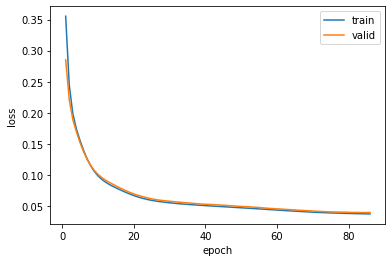

In [144]:
ma_window = 5

plt.plot(np.arange(len(all_train_losses)-ma_window + 1)+1, np.convolve(all_train_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.plot(np.arange(len(all_valid_losses)-ma_window + 1)+1, np.convolve(all_valid_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
#plt.ylim([0.01,0.06])

In [145]:
train_losses = per_sample_mse(model, training_generator)
print(train_losses[0:5])
print(np.mean(train_losses))

train_genuine_losses = np.array(train_losses)[y_train.cpu().numpy() == 0]
train_fraud_losses = np.array(train_losses)[y_train.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(train_genuine_losses))
print("Average genuine reconstruction error:", np.mean(train_fraud_losses))

[0.0039413115, 0.009499348, 0.014512614, 0.012666309, 0.021930164]
0.037629113
Average fraud reconstruction error: 0.037893213
Average genuine reconstruction error: 0.034351144


In [146]:
valid_losses = per_sample_mse(model, valid_generator)
print(valid_losses[0:5])
print(np.mean(valid_losses))

valid_genuine_losses = np.array(valid_losses)[y_valid.cpu().numpy() == 0]
valid_fraud_losses = np.array(valid_losses)[y_valid.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(valid_fraud_losses))
print("Average genuine reconstruction error:", np.mean(valid_genuine_losses))

[0.092695415, 0.010693915, 0.20118737, 0.024127873, 0.05813095]
0.03979701
Average fraud reconstruction error: 0.14965338
Average genuine reconstruction error: 0.03106757


In [147]:
test_losses = per_sample_mse(model, test_generator)
print(test_losses[0:5])
print(np.mean(test_losses))

test_genuine_losses = np.array(test_losses)[y_test.cpu().numpy() == 0]
test_fraud_losses = np.array(test_losses)[y_test.cpu().numpy() == 1]
print("Average fraud reconstruction error:", np.mean(test_fraud_losses))
print("Average genuine reconstruction error:", np.mean(test_genuine_losses))

[0.020247104, 0.0012014237, 0.0038813674, 0.028374523, 0.006181513]
0.04020127
Average fraud reconstruction error: 0.14284658
Average genuine reconstruction error: 0.031269755


In [148]:
print(X_train[0])
print(model(X_train[0].to(DEVICE)))

tensor([ 0.6086,  1.9965, -0.3345, -2.2000,  2.0069, -0.3308, -0.5019, -0.3334,
         1.5303, -0.5787, -0.7315, -0.4468, -0.4431, -0.4639, -0.4443,  2.2554,
        -0.3135,  2.5358, -0.6462, -0.8518, -0.9234, -0.1911, -0.2341, -0.4216,
        -0.2594, -0.5790, -0.3049, -0.2590, -0.1323, -0.5207, -0.2423, -0.5167,
        -0.2682, -0.1992, -0.1013, -0.4163, -0.1965, -0.4280, -0.2252],
       device='cuda:0')
tensor([ 0.4918,  1.9444, -0.2927, -2.0988,  1.9909, -0.3151, -0.5121, -0.3889,
         1.4662, -0.6544, -0.8527, -0.4153, -0.5230, -0.4900, -0.4597,  2.1504,
        -0.2936,  2.5219, -0.6144, -0.8113, -0.8816, -0.1961, -0.3152, -0.4131,
        -0.2648, -0.5580, -0.1479, -0.3537, -0.1731, -0.5382, -0.1594, -0.4608,
        -0.1665,  0.0048, -0.0857, -0.5323, -0.2456, -0.5391, -0.2840],
       device='cuda:0', grad_fn=<AddBackward0>)


In [149]:
# Plot Transactions MSE with labels

cutoff:0.0691097673773767


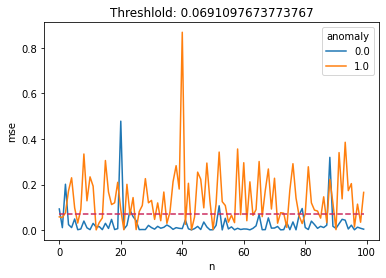

,accuracy,precision,recall,f1,auc,block_rate,fraud_rate,conversion_rate,average_precision
0,0.896813,0.408467,0.644986,0.500175,0.781856,0.126399,0.03253,0.873601,0.354456


In [193]:
plot_samples = 100

genuine_losses = valid_genuine_losses
fraud_losses = valid_fraud_losses

cut_off = np.percentile(genuine_losses, 92)

print(f"cutoff:{cut_off}")

# normal event
normal_events_mse = genuine_losses[0:plot_samples]
normal_events_df = pd.DataFrame({
	'mse': normal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.zeros(plot_samples)})

# abnormal event
abnormal_events_mse = fraud_losses[0:plot_samples]
abnormal_events_df = pd.DataFrame({
	'mse': abnormal_events_mse,
	'n': np.arange(0, plot_samples),
	'anomaly': np.ones(plot_samples)})

mse_df = pd.concat([normal_events_df, abnormal_events_df], ignore_index=True)
plot = sns.lineplot(x=mse_df.n, y=mse_df.mse, hue=mse_df.anomaly)

line = lines.Line2D(
	xdata=np.arange(0, plot_samples),
	ydata=np.full(plot_samples, cut_off),
	color='#CC2B5E',
	linewidth=1.5,
	linestyle='dashed')

plot.add_artist(line)
plt.title('Threshlold: {threshold}'.format(threshold=cut_off))
plt.show()

y_true = df_test["has_fraudulent_dispute"]
y_pred_proba = test_losses
y_pred = (y_pred_proba >= cut_off).astype(bool)
df_performances_one = pd_metrics(y_true, y_pred, y_pred_proba)
df_performances_one

In [191]:
df_outlier_score = pd.concat([df_test[["psp_reference"]].reset_index(drop=True), pd.Series(test_losses)], axis=1)
df_outlier_score.columns= ['psp_reference', 'outlier_score']
df_outlier_score.to_csv("outlier_score_July_December.csv", index=False)

In [192]:
df_outlier_score

,psp_reference,outlier_score
0,70119249768,0.020247
1,28072336569,0.001201
2,39014155829,0.003881
3,88323560627,0.028375
4,58489922712,0.006182
...,...,...
69141,61096039813,0.004453
69142,37712861918,0.038624
69143,17076786973,0.006643
69144,76999601451,0.001235
